In [1]:
%matplotlib inline
%env PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/home/ubuntu/im-photoz/Montage_v3.3/bin:/montage/bin

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from sklearn import neighbors
from sklearn.cross_validation import train_test_split
from sklearn.utils import check_random_state

env: PATH=/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/home/ubuntu/im-photoz/Montage_v3.3/bin:/montage/bin


In [2]:
def read_from_file(file_path, max_z=2):
    pixels = pd.DataFrame.from_csv(file_path)
    pixels = pixels[['objID', 'z', 'zErr', 'lup_u', 'lup_g', 'lup_r', 'lup_i', 'lup_z', 'distance_to_obj']]
    pixels = pixels[pixels['z']<=max_z]
    objects = np.unique(pixels['objID'])
    return pixels, objects

In [3]:
# Split training and testing sets by each OBJECT not each pixel
def split(pixels, objects, test_column=['z', 'zErr'], test_size=0.3, random_state=check_random_state(0),
          near_center=False, pixel_distance_to_center=1000):
    
    if near_center==True:
        pixels = pixels[pixels['distance_to_obj']<=pixel_distance_to_center]
    
    obj_X_train, obj_X_test, obj_y_train, obj_y_test = train_test_split(
                                                            objects, 
                                                            objects, 
                                                            test_size=test_size, 
                                                            random_state=random_state
                                                            )
    
    pc_test_col = pixels[[test_column[0], test_column[1], 'objID']]
    pc_no_test_col = pixels.drop(test_column, axis=1)
    
    X_train = pc_no_test_col[pc_no_test_col['objID'].isin(objects)]
    y_train = pc_test_col[pc_test_col['objID'].isin(objects)]
    X_test = pc_no_test_col[pc_no_test_col['objID'].isin(objects)]
    y_test = pc_test_col[pc_test_col['objID'].isin(objects)]
    
    X_train, X_test = map(normalize, [X_train, X_test])
    y_train = y_train.drop('objID', axis=1)
    y_test = y_test.drop('objID', axis=1)
    y_test = y_test.set_index(np.arange(0, len(y_test)))

    return X_train, X_test, y_train, y_test

In [4]:
def normalize(df):
    if 'objID' in df.columns:
        df = df.drop('objID', axis=1)
    if 'pixelID' in df.columns:
        df = df.drop('pixelID', axis=1)        
    result = (df-df.min())/(df.max()-df.min()) # not worry about zero denominator for now
    
    return result

In [5]:
def train_knn(X_train_normal, y_train, X_test_normal, n_neighbors=4):
    y_train = y_train.astype('float')
    knc = neighbors.KNeighborsRegressor(n_neighbors=n_neighbors)
    model = knc.fit(X_train_normal, y_train)
    y_predict = pd.DataFrame(knc.predict(X_test_normal), columns=['z', 'zErr'])
    return model, y_predict

In [6]:
def main(path):
    pixels, objects = read_from_file(path)
    X_train, X_test, y_train, y_test = split(pixels=pixels, objects=objects)
    model, y_predict = train_knn(X_train, y_train, X_test, 10)
    
    fig,((ax0,ax1),(ax2,ax3)) = plt.subplots(2,2,figsize=(15,15))

    ax0.set(xlim=(0,1), ylim=(0,1))
    ax0.set_xlabel("testing", fontsize=12)
    ax0.set_ylabel("prediction", fontsize=12)
    ax0.set_title("No Modification", fontsize=20)
    ax0.scatter(y_test.z, y_predict.z, marker='.', linewidth=0, color="#5DADE2")
    ax0.plot(np.linspace(0,1), np.linspace(0,1), linewidth=1.5, color="#EF4836")

    df_test_predict = pd.DataFrame({'y_test': y_test.z, 'y_predict':y_predict.z})
    df_mean = df_test_predict.groupby('y_test', as_index=False).mean()
    ax1.set(xlim=(0,1), ylim=(0,1))
    ax1.set_xlabel("testing", fontsize=12)
    ax1.set_ylabel("prediction", fontsize=12)
    ax1.set_title("Average", fontsize=20)
    ax1.scatter(df_mean.y_test, df_mean.y_predict, marker='.', linewidth=0, color="#9B59B6")
    ax1.plot(np.linspace(0,1), np.linspace(0,1), linewidth=1, color="#EF4836")

    df_test_predict = pd.DataFrame({'y_test': y_test.z, 'y_predict':y_predict.z})
    df_median = df_test_predict.groupby('y_test', as_index=False).median()
    ax2.set(xlim=(0,1), ylim=(0,1))
    ax2.set_xlabel("testing", fontsize=12)
    ax2.set_ylabel("prediction", fontsize=12)
    ax2.set_title("Median", fontsize=20)
    ax2.scatter(df_median.y_test, df_median.y_predict, marker='.', linewidth=0, color="#00B16A")
    ax2.plot(np.linspace(0,1), np.linspace(0,1), linewidth=1.5, color="#EF4836")

    ax3.set(xlim=(0,1), ylim=(0,1))
    ax3.set_xlabel("testing", fontsize=12)
    ax3.set_ylabel("prediction", fontsize=12)
    ax3.set_title("All Together", fontsize=20)
    ax3.scatter(df_mean.y_test, df_mean.y_predict, marker='.', linewidth=0, color="#9B59B6")
    ax3.scatter(df_median.y_test, df_median.y_predict, marker='.', linewidth=0, color="#00B16A")
    ax3.plot(np.linspace(0,1), np.linspace(0,1), linewidth=1.5, color="#EF4836")
    
    plt.savefig('result.png')
    
    return None

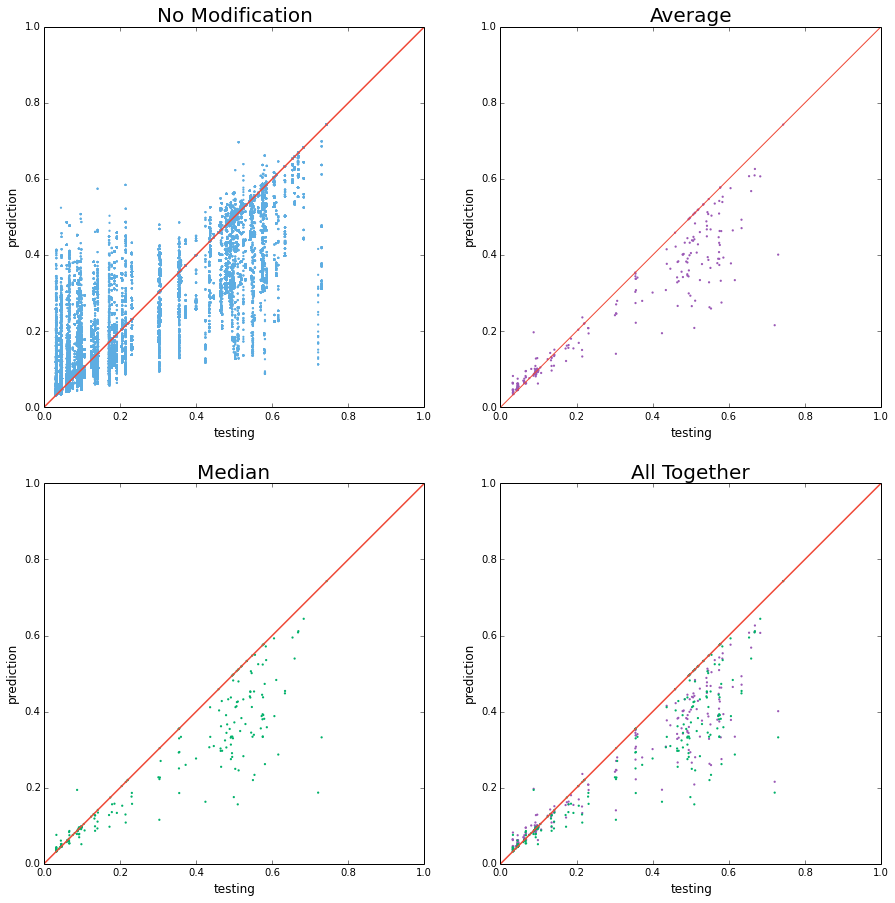

In [7]:
main('data/pixels/150,0-pixels.csv')

In [14]:
main('data/allsqfts.pixels')

MemoryError: 